In [1]:
# Import libraries

import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Create database connection

conn = psycopg2.connect(
    host = 'localhost',
    dbname = 'contoso_100k',
    user = 'postgres',
    password = 'Sund@ycouple91', # hide password before publish
    port = 5432
)

In [3]:
# Save query as string

query_rfm = '''
SELECT *
FROM vw_customer_rfm;
'''

In [4]:
# Execute SQL query and load into DataFrame

df = pd.read_sql(query_rfm, conn)

print(df.head())

C:\Users\User\AppData\Local\Temp\ipykernel_12864\1733600985.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query_rfm, conn)


   customerkey       customer_name last_purchase_date  recency  frequency  \
0           15     Julian McGuigan         2021-03-08     1139          1   
1          180   Gabriel Bosanquet         2023-08-28      236          2   
2          185  Gabrielle Castella         2019-06-01     1785          1   
3          243       Maya Atherton         2016-05-19     2893          1   
4          387    Tahlia Underwood         2023-11-16      156          3   

   monetary  rec_score  freq_score  mon_score rfm_score          rfm_segment  
0   1299.71          2           1          2     2-1-2       About To Sleep  
1   1103.35          5           3          2     5-3-2  Active Low Spenders  
2    666.45          2           1          2     2-1-2       About To Sleep  
3    148.90          1           1          1     1-1-1                 Lost  
4   2341.27          5           5          3     5-5-3                Loyal  


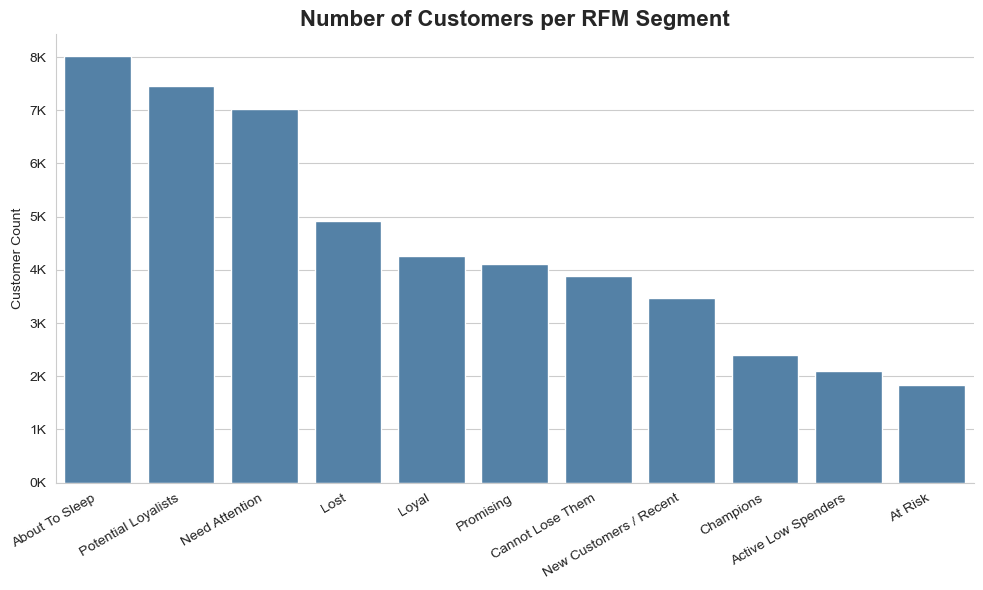

In [5]:
# Count the number of customers for each RFM segment, then order them
segment_count = (
    df['rfm_segment']
    .value_counts()
    .rename_axis('rfm_segment')
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
)

plt.figure(figsize=(10,6))
sns.set_style('whitegrid')

# Plot the number of customers per segment
sns.barplot(
    data=segment_count,
    x='rfm_segment',
    y='count',
    color='steelblue'
)

sns.despine() # Remove top/right borders
plt.title('Number of Customers per RFM Segment', weight='bold', fontsize=16)
plt.xlabel('')
plt.ylabel('Customer Count')

# Rotate x labels so they don’t overlap
plt.xticks(rotation=30, ha='right')

# Format y-axis to show K for thousands
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda y, _: f'{int(y/1000)}K')
)

plt.tight_layout()
plt.show()

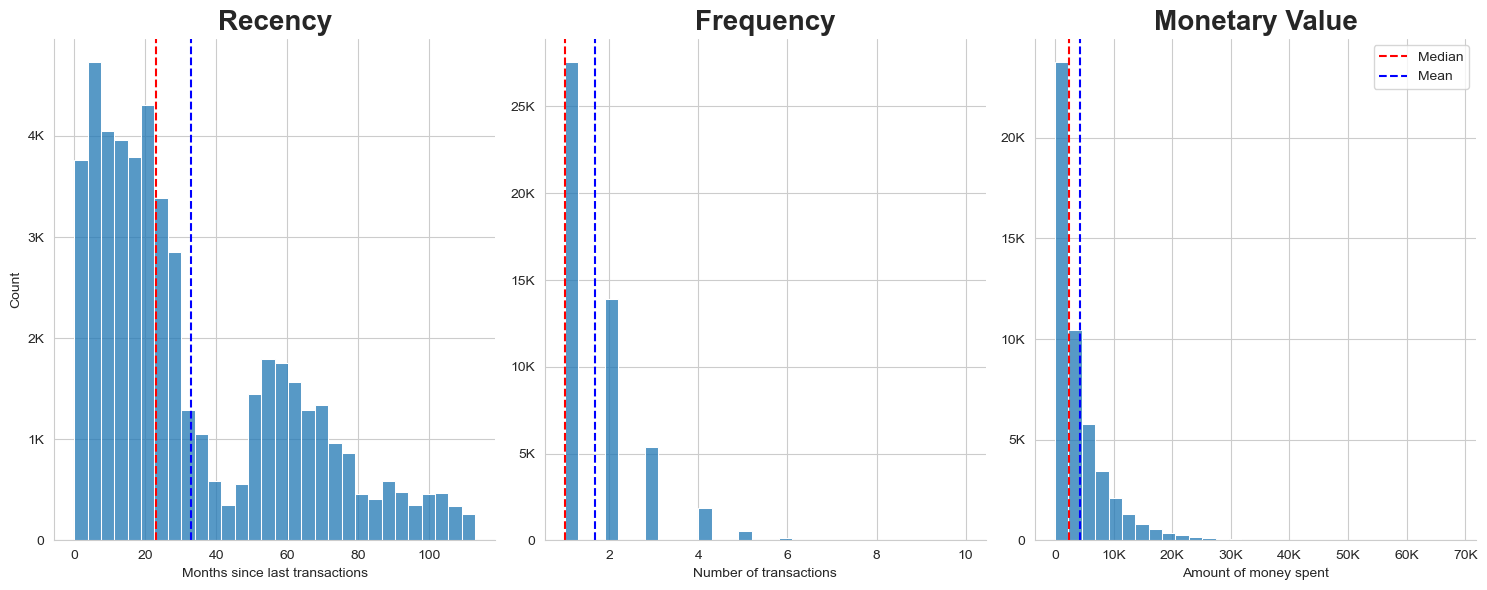

In [6]:
# Convert recency from days to months
df['recency_months'] = (df['recency'] / 30).round().astype(int)

# Columns to plot
cols = ['recency_months', 'frequency', 'monetary']

# Titles for each chart
title_map = {
    'recency_months': 'Recency',
    'frequency': 'Frequency',
    'monetary': 'Monetary Value'
}

# X-axis labels for each chart
xlabel_map = {
    'recency_months': 'Months since last transactions',
    'frequency': 'Number of transactions',
    'monetary': 'Amount of money spent'
}

# Create a 1x3 layout for the histograms
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
sns.set_style('ticks')

for i, col in enumerate(cols):
    sns.histplot(df[col], bins=30, ax=ax[i])

    # Set the chart title and x-label
    ax[i].set_title(title_map[col], fontsize=20, fontweight='bold')
    ax[i].set_xlabel(xlabel_map[col])

     # Add median and mean lines
    ax[i].axvline(df[col].median(), color='red', linestyle='--', label=f'Median')
    ax[i].axvline(df[col].mean(), color='blue', linestyle='--', label=f'Mean')

    # Create legend
    lg = ax[i].legend()
    
    # Remove y-labels for the 2nd and 3rd plots
    if i >= 1:
        ax[i].set_ylabel('')

    # Hide legend for all plots except the last one
    if i < len(cols) - 1:
        lg.set_visible(False)

    # Format x-axis to show K for thousands
    ax[i].xaxis.set_major_formatter(
        plt.FuncFormatter(lambda x, _: f'{int(x/1000)}K' if x >= 1000 else f'{int(x)}')
    )

    # Format y-axis to show K for thousands
    ax[i].yaxis.set_major_formatter(
        plt.FuncFormatter(lambda y, _: f'{int(y/1000)}K' if y >= 1000 else f'{int(y)}')
    )

sns.despine() # Remove borders
plt.tight_layout()
plt.show()

In [7]:
query_high_value_cust = '''
WITH customer_category_revenue AS (
	SELECT
		vcr.customerkey,
		vcr.rfm_segment,
		p.categoryname,
		p.subcategoryname,
		SUM(s.quantity) AS total_order,
		SUM(s.quantity * s.netprice / s.exchangerate) AS total_revenue_per_customer
	FROM vw_customer_rfm vcr
	JOIN sales s ON vcr.customerkey = s.customerkey
	JOIN product p ON s.productkey = p.productkey
	WHERE
		vcr.rfm_segment IN ('Champions', 'Loyal')
	GROUP BY
		vcr.customerkey,
		vcr.rfm_segment,
		p.categoryname,
		p.subcategoryname
)

SELECT
	rfm_segment,
	categoryname,
	subcategoryname,
	SUM(total_order) AS total_units,
	ROUND(SUM(total_revenue_per_customer)::NUMERIC, 2) AS total_revenue,
	ROUND(AVG(total_revenue_per_customer)::NUMERIC, 2) AS avg_revenue_per_customer,
	ROUND(
		(100.0 * SUM(total_revenue_per_customer) 
			/
		 SUM(SUM(total_revenue_per_customer)) OVER (PARTITION BY rfm_segment)
		)::NUMERIC
	, 2) AS revenue_share_pct
FROM customer_category_revenue
GROUP BY
	rfm_segment,
	categoryname,
	subcategoryname
ORDER BY 
	rfm_segment,
	total_revenue DESC;
'''

In [8]:
# Execute SQL query and load into DataFrame

df_high_value_cust = pd.read_sql(query_high_value_cust, conn)

df_high_value_cust

C:\Users\User\AppData\Local\Temp\ipykernel_12864\1079573545.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_high_value_cust = pd.read_sql(query_high_value_cust, conn)


,rfm_segment,categoryname,subcategoryname,total_units,total_revenue,avg_revenue_per_customer,revenue_share_pct
0,Champions,Computers,Desktops,6429.0,4342841.08,3153.84,18.05
1,Champions,Computers,Projectors & Screens,2431.0,2525449.53,3867.46,10.50
2,Champions,Computers,Laptops,2461.0,2036097.78,3156.74,8.46
3,Champions,Cell phones,Smart phones & PDAs,6027.0,1932867.33,1515.97,8.03
4,Champions,Cell phones,Touch Screen Phones,5313.0,1801105.50,1514.81,7.49
...,...,...,...,...,...,...,...
59,Loyal,Cell phones,Home & Office Phones,3557.0,128415.24,127.65,0.36
60,Loyal,Home Appliances,Lamps,668.0,123714.52,665.13,0.35
61,Loyal,Cell phones,Cell phones Accessories,4092.0,117803.78,107.09,0.33
62,Loyal,Games and Toys,Boxed Games,5869.0,41670.90,27.76,0.12


<Figure size 1200x600 with 0 Axes>

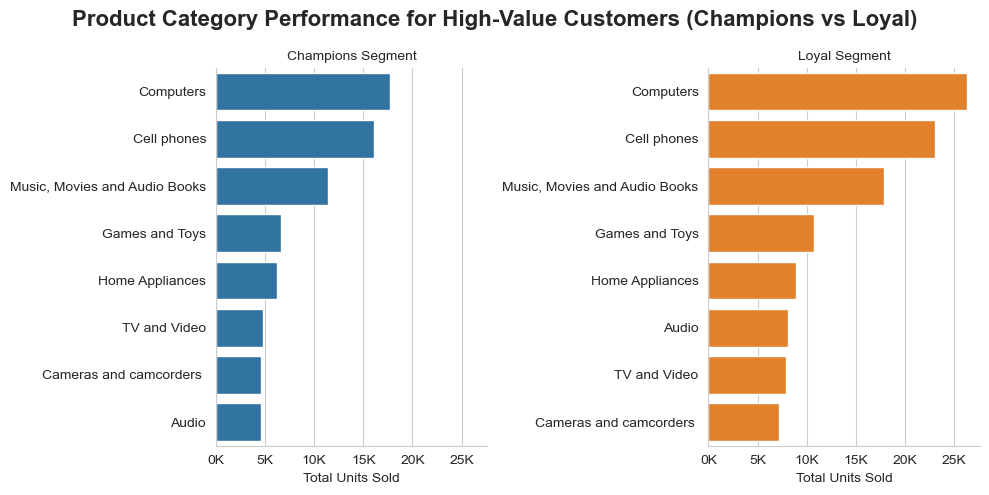

In [9]:
# Aggregate total units sold per category for each RFM segment then sort within each segment to identify the highest-volume categories
df_category = (
    df_high_value_cust
        .groupby(['rfm_segment', 'categoryname'], as_index=False)['total_units']
        .sum()
        .sort_values(by=['rfm_segment', 'total_units'], ascending=[True, False])
)

plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')

# Create a facet bar chart by RFM segment (Champions vs Loyal)
g = sns.catplot(
    data=df_category,
    kind='bar',
    x='total_units',
    y='categoryname',
    col='rfm_segment',
    sharey=False,
    hue='rfm_segment',
    height=5,
    legend=False
)

# Set the main figure title
g.figure.suptitle(
    'Product Category Performance for High-Value Customers (Champions vs Loyal)',
    fontsize=16, weight='bold'
)

# Set axis labels
g.set_axis_labels('Total Units Sold', '')

# Set panel subtitles automatically based on rfm_segment
g.set_titles('{col_name} Segment')

# Format x-axis to display values in thousands
ax = g.axes[0,0] # shared x-axis, applies to both panels
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000)}K'))

plt.tight_layout()
plt.show()

In [10]:
# Set a threshold value for revenue share percentage
threshold = 3

df_plot = df_high_value_cust.copy()

# Create a new column 'subcat_group':
# - If the revenue share percentage of a subcategory is below the threshold, label it as 'Others'
# - Otherwise, keep the original subcategory name
df_plot['subcat_group'] = df_plot.apply(
    lambda row: 'Others' if row['revenue_share_pct'] < threshold else row['subcategoryname'],
    axis=1
)

df_plot

,rfm_segment,categoryname,subcategoryname,total_units,total_revenue,avg_revenue_per_customer,revenue_share_pct,subcat_group
0,Champions,Computers,Desktops,6429.0,4342841.08,3153.84,18.05,Desktops
1,Champions,Computers,Projectors & Screens,2431.0,2525449.53,3867.46,10.50,Projectors & Screens
2,Champions,Computers,Laptops,2461.0,2036097.78,3156.74,8.46,Laptops
3,Champions,Cell phones,Smart phones & PDAs,6027.0,1932867.33,1515.97,8.03,Smart phones & PDAs
4,Champions,Cell phones,Touch Screen Phones,5313.0,1801105.50,1514.81,7.49,Touch Screen Phones
...,...,...,...,...,...,...,...,...
59,Loyal,Cell phones,Home & Office Phones,3557.0,128415.24,127.65,0.36,Others
60,Loyal,Home Appliances,Lamps,668.0,123714.52,665.13,0.35,Others
61,Loyal,Cell phones,Cell phones Accessories,4092.0,117803.78,107.09,0.33,Others
62,Loyal,Games and Toys,Boxed Games,5869.0,41670.90,27.76,0.12,Others


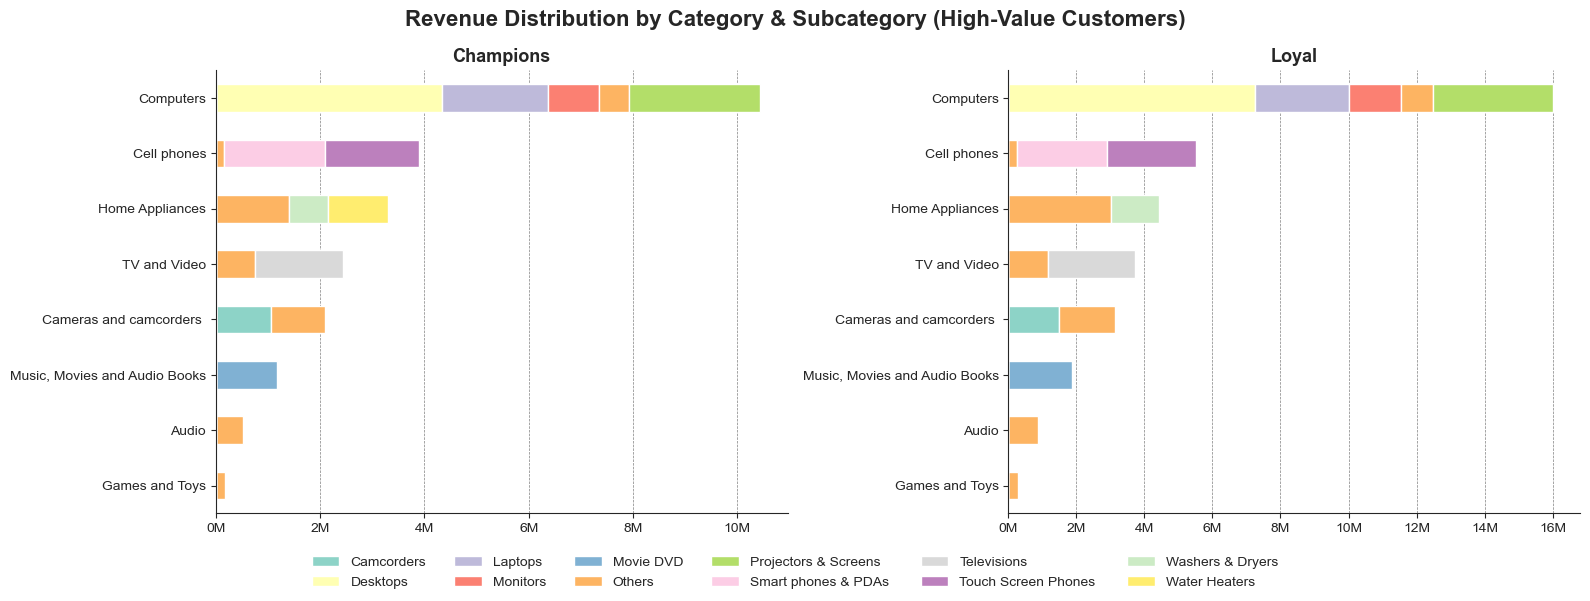

In [ ]:
# Get the unique segment
segments = df_plot['rfm_segment'].unique()

# Create a figure with 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style('ticks')

for i, seg in enumerate(segments):
    df_seg = df_plot[df_plot['rfm_segment'] == seg]

    # Pivot the data, prepare to plot
    df_pivot = df_seg.pivot_table(
        index='categoryname',
        columns='subcat_group',
        values='total_revenue',
        aggfunc='sum'
    ).fillna(0)

    # Sort rows by total revenue ascending
    df_pivot = df_pivot.loc[df_pivot.sum(axis=1).sort_values().index]

    # Generate a color palette with enough unique colors for all subcategories
    colors = sns.color_palette("Set3", n_colors=len(df_pivot.columns))

    # Plot horizontal stacked bar chart
    df_pivot.plot(
        kind='barh',
        stacked=True,
        ax=ax[i],
        color=colors,
        legend=False
    )

    # Customize plot title and axis
    ax[i].set_title(f'{seg}', fontsize=13, weight='bold')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')

    # Convert x-axis to millions
    ax[i].get_xaxis().set_major_formatter(
        plt.FuncFormatter(lambda x, _: f'{int(x/1_000_000)}M')
    )

    # Add vertical gridlines for better readability
    ax[i].grid(axis='x', color='gray', linestyle='--', linewidth=0.5)

# Add a legend at the bottom
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, frameon=False)

sns.despine()
plt.suptitle('Revenue Distribution by Category & Subcategory (High-Value Customers)',
             fontsize=16, weight='bold')

# Adjust layout for legend
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_12864\3884911400.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda t: (t['total_revenue'] * t['revenue_share_pct']).sum() / t['total_revenue'].sum())


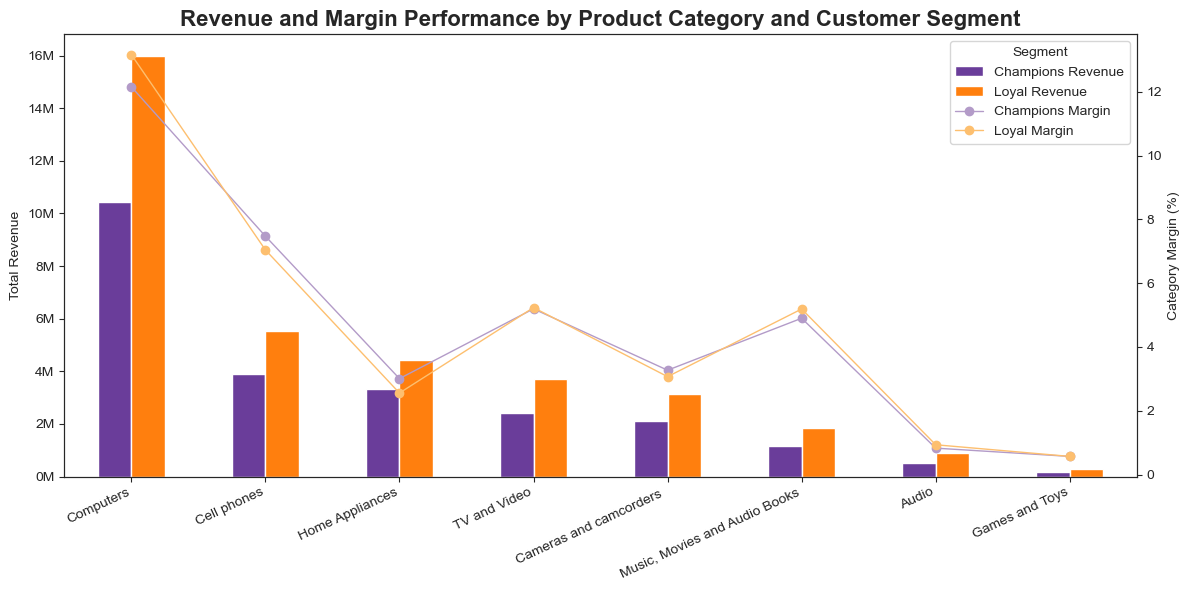

In [ ]:
# Sum total revenue per segment and category for bar chart
df_cat_revenue = (
    df_high_value_cust
    .groupby(['rfm_segment', 'categoryname'], as_index=False)['total_revenue']
    .sum()
)

# Calculate weighted category margin for line chart
df_margin_cat = (
    df_high_value_cust
    .groupby(['rfm_segment', 'categoryname'])
    .apply(lambda t: (t['total_revenue'] * t['revenue_share_pct']).sum() / t['total_revenue'].sum())
    .reset_index(name='cat_margin_pct')
)

# Order category by total revenue
category_order = (
    df_cat_revenue
    .groupby('categoryname')['total_revenue']
    .sum()
    .sort_values(ascending=False)
    .index
    .to_list()
)

# Pivot data for plotting
pivot_bar = df_cat_revenue.pivot_table(
    index='categoryname',
    columns='rfm_segment',
    values='total_revenue'
).reindex(category_order)

pivot_line = df_margin_cat.pivot_table(
    index='categoryname',
    columns='rfm_segment',
    values='cat_margin_pct'
).reindex(category_order)

# Rename columns for better legend labels
pivot_bar = pivot_bar.rename(
    columns={seg: f'{seg} Revenue' for seg in pivot_bar.columns}
)

pivot_line = pivot_line.rename(
    columns={seg: f'{seg} Margin' for seg in pivot_line.columns}
)

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Color list per segment for bar chart
bar_colors = {
    'Champions Revenue': '#6A3D9A',
    'Loyal Revenue': '#FF7F0E'
}

# Plot bar chart
pivot_bar.plot(
    kind='bar',
    ax=ax,
    color=bar_colors,
    legend=False
)

# Format axis
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
ax.set_ylabel('Total Revenue')

# Convert y-axis to millions
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1_000_000)}M'))

# Plot line chart on secondary y-axis
ax2 = ax.twinx()

# Color list per segment for line chart
line_colors = {
    'Champions Margin': '#B39BC8',
    'Loyal Margin': '#FDBF6F'
}

# Plot line chart
pivot_line.plot(
    kind='line',
    ax=ax2,
    marker='o',
    linewidth=1,
    color=line_colors,
    legend=False
)

# Format label of y-axis
ax2.set_ylabel('Category Margin (%)')

# Get the legends and combine them
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(
    handles1 + handles2,
    labels1 + labels2,
    loc='upper right',
    title='Segment'
)

# Add title
plt.title('Revenue and Margin Performance by Product Category and Customer Segment', fontsize=16, weight='bold')

plt.tight_layout()
plt.show()